In [2]:
##Modules for simple measurement

import numpy as np

import qcodes as qc

## Multidimensional scanning module
from qcodes.dataset import (
    LinSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
## Dummy instruments for generating synthetic data
from qcodes.instrument_drivers.mock_instruments import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)
## Using interactive widget
from qcodes.interactive_widget import experiments_widget


In [3]:
##Creating two dummy instruments: a digital-to-analog converter (dac) with two channels, 
##and a digital multimeter (dmm) to measure the signal produced:

# A dummy signal generator with two parameters ch1 and ch2
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])

# A dummy digital multimeter that generates a synthetic data depending
# on the values set on the setter_instr, in this case the dummy dac
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

In [4]:
## snapshot: two inspect the configuration of the instrument
##our "dmm" has two parameter (v1 and v2), that correspond the two channels of "dac"
dmm.print_readable_snapshot()

dmm:
	parameter value
--------------------------------------------------------------------------------
IDN :	None 
v1  :	0 (V)
v2  :	0 (V)


In [5]:
dac.ch1(1.1)

In [6]:
dmm.v1()

3.9184868784295603

In [7]:
station = qc.Station()

In [8]:
station.add_component(dac)
station.add_component(dmm)

'dmm'

In [9]:
_ = station.snapshot()

In [10]:
initialise_or_create_database_at("~/experiments_for_15_mins.db")

In [11]:
qc.config.core.db_location

'~/experiments_for_15_mins.db'

In [12]:
tutorial_exp = load_or_create_experiment(
    experiment_name="tutorial_exp",
    sample_name="synthetic data"
)

In [13]:
context_meas = Measurement(exp=tutorial_exp, station=station, name='context_example')

In [14]:
# Register the independent parameter...
context_meas.register_parameter(dac.ch1)
# ...then register the dependent parameter
context_meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))

In [15]:
# Time for periodic background database writes
context_meas.write_period = 2

with context_meas.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))

    # Convenient to have for plotting and data access
    dataset = datasaver.dataset

Starting experimental run with id: 7. 


In [16]:
# Setting up a doNd measurement
sweep_1 = LinSweep(dac.ch1, -1, 1, 20, 0.01)
sweep_2 = LinSweep(dac.ch2, -1, 1, 20, 0.01)

In [17]:
dond(
    sweep_1,                          # 1st independent parameter
    sweep_2,                          # 2nd independent parameter
    dmm.v1,                           # 1st dependent parameter
    dmm.v2,                           # 2nd dependent parameter
    measurement_name="dond_example",  # Set the measurement name
    exp=tutorial_exp,                 # Set the experiment to save data to.
    show_progress=True                # Optional progress bar
)

Starting experimental run with id: 8. Using 'qcodes.dataset.dond'


  0%|          | 0/400 [00:00<?, ?it/s]

(dond_example #8@C:\Users\patrick\experiments_for_15_mins.db
 -----------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 (None,),
 (None,))

In [18]:
experiments()

[tutorial_exp#synthetic data#1@C:\Users\patrick\experiments_for_15_mins.db
 -------------------------------------------------------------------------
 1-context_example-1-dac_ch1,dmm_v1-10
 2-context_example-2-dac_ch1,dmm_v1-10
 3-context_example-3-dac_ch1,dmm_v1-10
 4-dond_example-4-dac_ch1,dac_ch2,dmm_v1,dmm_v2-800
 5-context_example-5-dac_ch1,dmm_v1-10
 6-dond_example-6-dac_ch1,dac_ch2,dmm_v1,dmm_v2-800
 7-context_example-7-dac_ch1,dmm_v1-10
 8-dond_example-8-dac_ch1,dac_ch2,dmm_v1,dmm_v2-800]

In [19]:
tutorial_exp.data_sets()

[context_example #1@C:\Users\patrick\experiments_for_15_mins.db
 --------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric,
 context_example #2@C:\Users\patrick\experiments_for_15_mins.db
 --------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric,
 context_example #3@C:\Users\patrick\experiments_for_15_mins.db
 --------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric,
 dond_example #4@C:\Users\patrick\experiments_for_15_mins.db
 -----------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 context_example #5@C:\Users\patrick\experiments_for_15_mins.db
 --------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric,
 dond_example #6@C:\Users\patrick\experiments_for_15_mins.db
 -----------------------------------------------------------
 dac_ch1 - numeri

In [20]:
dataset_1d = load_by_run_spec(experiment_name='tutorial_exp', captured_run_id=1)
dataset_2d = load_by_run_spec(experiment_name='tutorial_exp', captured_run_id=2)

([<Axes: title={'center': 'Run #1, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>],
 [None])

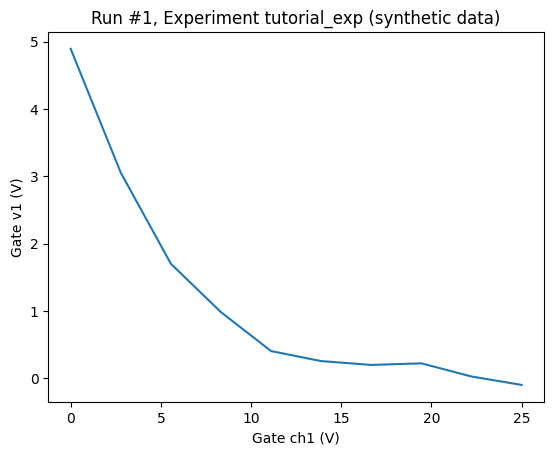

In [21]:
# Plotting 1d dataset
plot_dataset(dataset_1d)

([<Axes: title={'center': 'Run #2, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>],
 [None])

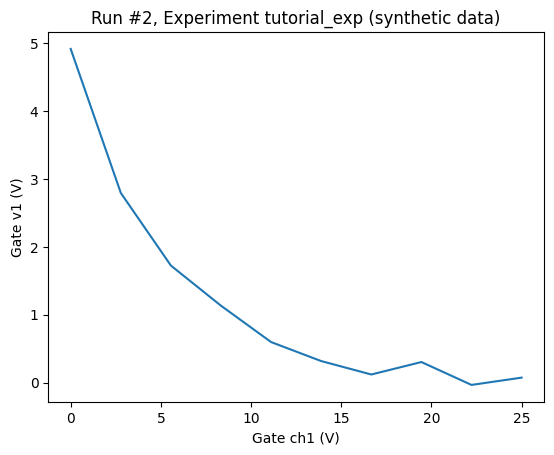

In [22]:
# Plotting 2d dataset as heatmaps
plot_dataset(dataset_2d)

In [23]:
# All data for all parameters
dataset_1d.get_parameter_data()

{'dmm_v1': {'dmm_v1': array([ 4.89371185,  3.05478573,  1.70166574,  0.98294858,  0.40518056,
          0.25652605,  0.19968007,  0.22288353,  0.027542  , -0.09749412]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [24]:
# Data for independent parameter
dataset_1d.get_parameter_data('dac_ch1')

{'dac_ch1': {'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [25]:
# Data for dependent parameter
dataset_1d.get_parameter_data('dmm_v1')

{'dmm_v1': {'dmm_v1': array([ 4.89371185,  3.05478573,  1.70166574,  0.98294858,  0.40518056,
          0.25652605,  0.19968007,  0.22288353,  0.027542  , -0.09749412]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [26]:
df = dataset_1d.to_pandas_dataframe()
df.head()

,dmm_v1
dac_ch1,
0.000000,4.893712
2.777778,3.054786
5.555556,1.701666
8.333333,0.982949
11.111111,0.405181


In [27]:
xr_dataset = dataset_1d.to_xarray_dataset()
xr_dataset

<xarray.Dataset> Size: 160B
Dimensions:  (dac_ch1: 10)
Coordinates:
  * dac_ch1  (dac_ch1) float64 80B 0.0 2.778 5.556 8.333 ... 19.44 22.22 25.0
Data variables:
    dmm_v1   (dac_ch1) float64 80B 4.894 3.055 1.702 ... 0.2229 0.02754 -0.09749
Attributes: (12/14)
    ds_name:                  context_example
    sample_name:              synthetic data
    exp_name:                 tutorial_exp
    snapshot:                 {"station": {"instruments": {"dac": {"functions...
    guid:                     3bc6772f-0000-0000-0000-018fea6f58e0
    run_timestamp:            2024-06-05 18:05:16
    ...                       ...
    captured_counter:         1
    run_id:                   1
    run_description:          {"version": 3, "interdependencies": {"paramspec...
    parent_dataset_links:     []
    run_timestamp_raw:        1717625116.9398372
    completed_timestamp_raw:  1717625116.9760935

In [28]:
experiments_widget(sort_by="timestamp")